In [1]:
import torch
from torch import nn
from torch.nn import functional as F
from torch import optim
import numpy as np
import pandas as pd
from stochastic_rnn import StochasticLSTM
from variational_module import MCDualOutputModule
from train_utils import train_model, BCMetric

In [2]:
from sklearn.preprocessing import minmax_scale
from sklearn.model_selection import train_test_split

In [3]:
from classification_uncertainty_utils import aleatoric_uncertainty, epistemic_uncertainty, uncertainty_avg, score_avg

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
np.random.seed(1234)
torch.manual_seed(1234)

In [6]:
training_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Training.data", sep=',', dtype=np.float32)
testing_table = pd.read_table("./data/hill-valley/Hill_Valley_with_noise_Testing.data", sep=',', dtype=np.float32)

In [7]:
training_table.head()

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X92,X93,X94,X95,X96,X97,X98,X99,X100,class
0,39.020000,36.490002,38.200001,38.849998,39.380001,39.740002,37.020000,39.529999,38.810001,38.790001,...,36.619999,36.919998,38.799999,38.520000,38.070000,36.730000,39.459999,37.500000,39.099998,0.0
1,1.830000,1.710000,1.770000,1.770000,1.680000,1.780000,1.800000,1.700000,1.750000,1.780000,...,1.800000,1.790000,1.770000,1.740000,1.740000,1.800000,1.780000,1.750000,1.690000,1.0
2,68177.687500,66138.421875,72981.882812,74304.328125,67549.656250,69367.343750,69169.406250,73268.609375,74465.843750,72503.367188,...,73438.882812,71053.351562,71112.617188,74916.476562,72571.578125,66348.968750,71063.718750,67404.273438,74920.242188,1.0
3,44889.058594,39191.859375,40728.460938,38576.359375,45876.058594,47034.000000,46611.429688,37668.320312,40980.890625,38466.148438,...,42625.671875,40684.199219,46960.730469,44546.800781,45410.531250,47139.441406,43095.679688,40888.339844,39615.191406,0.0
4,5.700000,5.400000,5.280000,5.380000,5.270000,5.610000,6.000000,5.380000,5.340000,5.870000,...,5.170000,5.670000,5.600000,5.940000,5.730000,5.220000,5.300000,5.730000,5.910000,0.0


In [8]:
dim = 1
seq_length = 100
DROP = 0.5
ls = 1e-2
tau = 1

In [9]:
x_train = minmax_scale(training_table.drop("class", axis=1).values, axis=1)
y_train = training_table["class"].values
x_test = minmax_scale(testing_table.drop("class", axis=1).values, axis=1)
y_test = testing_table["class"].values

x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.3, random_state=42)

N = len(y_train)

train_dl = torch.utils.data.DataLoader(
        [(x_train[i], y_train[i]) for i in range(len(y_train))],
        batch_size=10,
        shuffle=True
)
val_dl = torch.utils.data.DataLoader(
        [(x_val[i], y_val[i]) for i in range(len(y_val))],
        batch_size=10,
        shuffle=False
)
test_dl = torch.utils.data.DataLoader(
        [(x_test[i], y_test[i]) for i in range(len(y_test))],
        batch_size=len(y_test),
        shuffle=False
)

In [10]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.rnn = StochasticLSTM(1, 10)
        self.fc = nn.Linear(10, 1)

    def regularizer(self):
        length_scale = ls
        precision = tau
        
        # Weight and bias regularizer
        weight_sum, bias_sum, dropout_reg = self.rnn.regularizer()
        
        return (weight_sum + bias_sum + dropout_reg) * 0.5 * length_scale**2 / precision

    def forward(self, x: torch.Tensor):
        out, _ = self.rnn(x)
        out = out[-1]
        out = torch.tanh(out)
        pre_sigmoid = self.fc(out).flatten()
        post_sigmoid = torch.sigmoid(pre_sigmoid)
        return post_sigmoid, pre_sigmoid

In [11]:
net = Net()
def criterion(post_sigmoid, pre_sigmoid, label):
    return F.binary_cross_entropy_with_logits(pre_sigmoid, label)

optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
net.rnn.first_layer.p_logit.item(), net.rnn.first_layer.p_logit.sigmoid().item()

(0.0461304634809494, 0.5115305781364441)

In [13]:
metrics = [BCMetric()]

In [14]:
%%time
net = train_model(net, train_dl, val_dl, criterion, optimizer, "hill-valley-concrete-model.pt", 100, metrics=metrics, patience=5)

[1, 100.00%] train loss: 0.697775
[1, 100.00%] validate loss: 0.722033
Accuracy = 0.484
[2, 100.00%] train loss: 0.686483
[2, 100.00%] validate loss: 0.700622
Accuracy = 0.484
[3, 100.00%] train loss: 0.646859
[3, 100.00%] validate loss: 0.623990
Accuracy = 0.621
[4, 100.00%] train loss: 0.535578
[4, 100.00%] validate loss: 0.507431
Accuracy = 0.698
[5, 100.00%] train loss: 0.446585
[5, 100.00%] validate loss: 0.409110
Accuracy = 0.743
[6, 100.00%] train loss: 0.352934
[6, 100.00%] validate loss: 0.339454
Accuracy = 0.776
[7, 100.00%] train loss: 0.285912
[7, 100.00%] validate loss: 0.263185
Accuracy = 0.802
[8, 100.00%] train loss: 0.237406
[8, 100.00%] validate loss: 0.217029
Accuracy = 0.823
[9, 100.00%] train loss: 0.208776
[9, 100.00%] validate loss: 0.213211
Accuracy = 0.838
[10, 100.00%] train loss: 0.166768
[10, 100.00%] validate loss: 0.145287
Accuracy = 0.853
[11, 100.00%] train loss: 0.154308
[11, 100.00%] validate loss: 0.161741
Accuracy = 0.865
Retry 1/5
[12, 100.00%] trai

In [15]:
net.rnn.first_layer.p_logit.item(), net.rnn.first_layer.p_logit.sigmoid().item()

(-0.24041439592838287, 0.44018420577049255)

In [16]:
stochastic_net = MCDualOutputModule(net)

### Test

In [17]:
stochastic_net.eval()
acc = 0.0
with torch.no_grad():
    for i, (x, y) in enumerate(test_dl):
        post_sigmoids, pre_sigmoids = stochastic_net(x.transpose(-2,-3))
        uncertainties = uncertainty_avg(post_sigmoids)
        scores = score_avg(post_sigmoids)
        predictions = torch.round(scores)
        acc += (y == predictions).sum().item()

acc /= len(test_dl.dataset)
print("Accuracy = %.2f%%" % (acc * 100))

Accuracy = 100.00%


In [18]:
A = aleatoric_uncertainty(post_sigmoids)
E = epistemic_uncertainty(post_sigmoids)

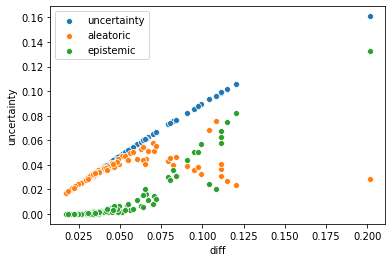

In [19]:
dist = torch.abs(y - scores)
sns.scatterplot(x=dist, y=uncertainties)
sns.scatterplot(x=dist, y=A)
sns.scatterplot(x=dist, y=E)
plt.xlabel("diff")
plt.ylabel("uncertainty")
plt.legend(labels=['uncertainty', 'aleatoric', 'epistemic'])

### Spread pre and post sigmoid analysis

In [20]:
T, B = pre_sigmoids.shape
pre_sigmoid_df = pd.DataFrame(columns=["entry","value"])
post_sigmoid_df = pd.DataFrame(columns=["entry","value"])
for i in range(T):
    for j in range(20):
        pre_sigmoid_df.loc[i*B + j] = (j+1, pre_sigmoids[i,j])
        post_sigmoid_df.loc[i*B + j] = (j+1, post_sigmoids[i,j])

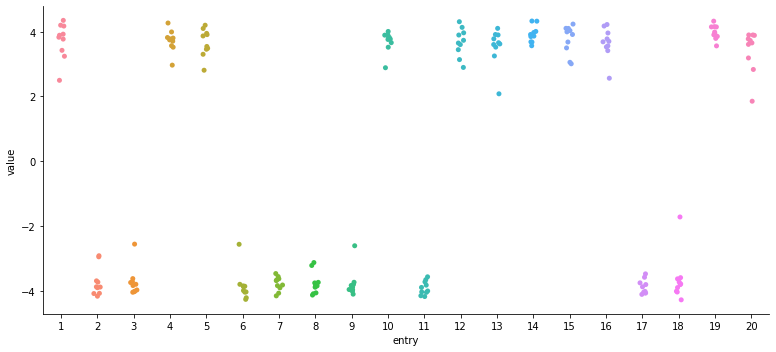

In [21]:
plot = sns.catplot(x="entry", y="value", data=pre_sigmoid_df)
plot.fig.set_figwidth(12)

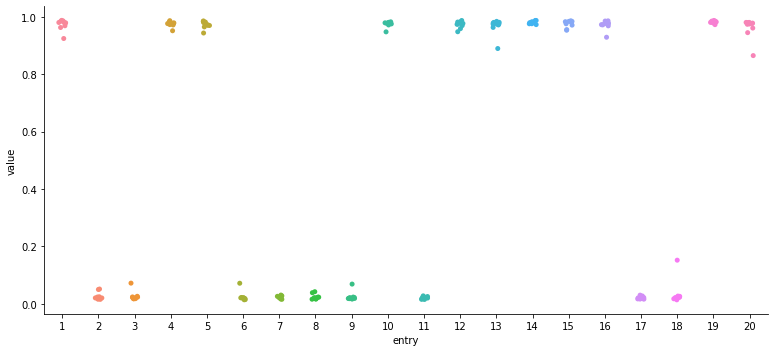

In [22]:
plot = sns.catplot(x="entry", y="value", data=post_sigmoid_df)
plot.fig.set_figwidth(12)

### Flat line test

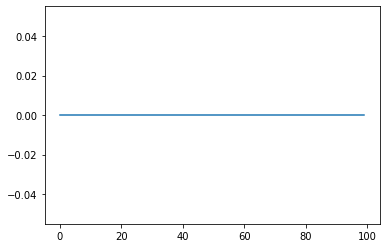

predictions tensor([0.9624, 0.9728])
uncertainties tensor([0.0362, 0.0264])


In [23]:
new_x_test = minmax_scale(np.full((2, 100), 0., dtype=np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

stochastic_net.eval()
with torch.no_grad():
    outputs,_ = stochastic_net(new_x_test)
    uncertainties = uncertainty_avg(outputs)
    scores = score_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)
print("uncertainties", uncertainties)

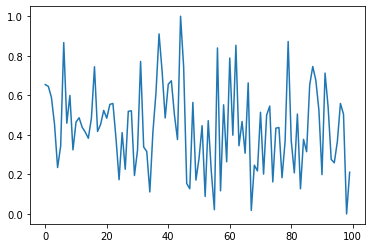

predictions tensor([0.0310, 0.6939])
uncertainties tensor([0.0300, 0.2124])


In [24]:
new_x_test = minmax_scale(np.random.randn(2, 100).astype(np.float32), axis=1)
new_x_test = np.expand_dims(new_x_test, axis=-1)
new_x_test = new_x_test.swapaxes(-2,-3)
new_x_test = torch.tensor(new_x_test)

stochastic_net.eval()
with torch.no_grad():
    outputs,_ = stochastic_net(new_x_test)
    uncertainties = uncertainty_avg(outputs)
    scores = score_avg(outputs)

plt.plot(new_x_test[:,0])
plt.show()
print("predictions", scores)
print("uncertainties", uncertainties)

### Note
In binary classification, the maximum uncertainty is 0.25 (need to verify this), and the minimum is 0.